#Amazon Fine Food Reviews Analysis

 Importing all the required Libraries

In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")



import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

#Mounting the drive
As I have downloaded the dataset from https://www.kaggle.com/snap/amazon-fine-food-reviews straight in my drive.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#[1]Loading the data
#The dataset is available in two forms


1.   csv file
2.   SQLite Database




As reviews with score 3 are not of much importance because they are neutral in nature .

Ignore those reviews.


In [4]:

con = sqlite3.connect('/content/drive/MyDrive/Applied AI/database.sqlite') 


filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 5000""", con) 

# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return "Negative"
    return "Positive"


actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(5)

Number of data points in our data (5000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,Positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,Negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,Positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,Negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,Positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


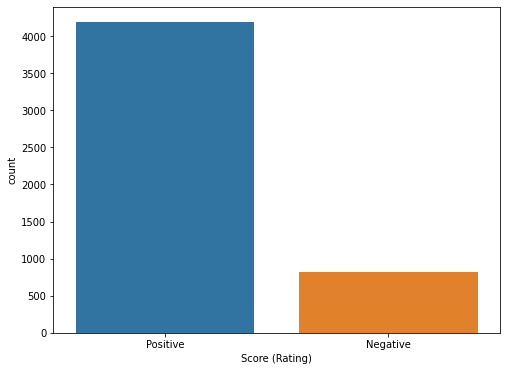

In [5]:

plt.figure(figsize=(8,6))
sns.countplot(x='Score', data=filtered_data)
plt.xlabel('Score (Rating)')
plt.show()

**Exploratory Data Analysis**

[2] **Data Cleaning: Deduplication**

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data. Following is an example:

In [6]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As can be seen above the same user has multiple reviews of the with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that

ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)

ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [7]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('Id', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
sorted_data.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,Positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,Negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,Positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,Negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,Positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [8]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
#Getting a rough idea of how many entries are left.
final.shape

(4986, 10)

In [9]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

99.72

In [10]:
#helpfulnessnumerator are the people who said "Yes" , the review was helpful while #helpfulnessDenominator are the total number of people who reacted "Yes + No".

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND HelpfulnessNumerator > HelpfulnessDenominator
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
print(final.shape)

(4986, 10)


In [14]:
#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

Positive    4178
Negative     808
Name: Score, dtype: int64

#[3]. Text Preprocessing.
Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

Begin by removing the html tags

1.   Remove any punctuations or limited set of special characters like , or . or # etc.
2.   Check if the word is made up of english letters and is not alpha-numeric.
3. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters).
4.Convert the word to lowercase
5.Remove Stopwords
6.Finally Snowball Stemming the word (it was obsereved to be better 
than Porter Stemming)


After which we collect the words used to describe positive and negative reviews

In [15]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.
This is not jerky, this is processed, hard like a rock, very greasy and stale smelling stripe of something that you can't break into anything smaller than 2 inches long and that certainly is not the size of a training treat! The dogs- 45lb dogs that will eat anything- were not impressed, it was hard to chew, and it sounded like they were crunching rocks, most of them spat it out after a few chews, left it there, this would be the first time they would not eat something in their entire lives, these dogs will work for lettuce. Where is a zero star button?
Aboulutely love Popchips!I first tried these healthy chips at a marathon i did in California. I like this variety pack because i got to try alot of the flavors ive never had.
M

In [16]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)
print('='*50)
print(sent_1000)
print('='*50)
print(sent_150)
print('='*50)
print(sent_4900)
print('='*50)

I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.
This is not jerky, this is processed, hard like a rock, very greasy and stale smelling stripe of something that you can't break into anything smaller than 2 inches long and that certainly is not the size of a training treat! The dogs- 45lb dogs that will eat anything- were not impressed, it was hard to chew, and it sounded like they were crunching rocks, most of them spat it out after a few chews, left it there, this would be the first time they would not eat something in their entire lives, these dogs will work for lettuce. Where is a zero star button?
Aboulutely love Popchips!I first tried these healthy chips at a marathon i did in California. I like this variety pack because i got to try alot of the flavors ive never had.
M

In [17]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.
This is not jerky, this is processed, hard like a rock, very greasy and stale smelling stripe of something that you can't break into anything smaller than 2 inches long and that certainly is not the size of a training treat! The dogs- 45lb dogs that will eat anything- were not impressed, it was hard to chew, and it sounded like they were crunching rocks, most of them spat it out after a few chews, left it there, this would be the first time they would not eat something in their entire lives, these dogs will work for lettuce. Where is a zero star button?
Aboulutely love Popchips!I first tried these healthy chips at a marathon i did in California. I like this variety pack because i got to try alot of the flavors ive never had.
M

In [18]:
#decontracted Words like don't , ll 
#https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase



In [19]:

sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Aboulutely love Popchips!I first tried these healthy chips at a marathon i did in California. I like this variety pack because i got to try alot of the flavors ive never had.


In [20]:
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.


In [21]:
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Aboulutely love Popchips I first tried these healthy chips at a marathon i did in California I like this variety pack because i got to try alot of the flavors ive never had 


In [22]:
stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [23]:
# Combining all the above statements
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 4986/4986 [00:02<00:00, 2428.10it/s]


In [24]:
preprocessed_reviews[1500]

'aboulutely love popchips first tried healthy chips marathon california like variety pack got try alot flavors ive never'

In [25]:
#bow
score=final['Score'] #storing all scores in a new series.
print(type(score))
print(score.shape)

<class 'pandas.core.series.Series'>
(4986,)


In [26]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aahhhs', 'aback', 'abandon', 'abates', 'abbott', 'abby', 'abdominal', 'abiding', 'ability']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 12997)
the number of unique words  12997


In [27]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


In [28]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['ability', 'able', 'able find', 'able get', 'absolute', 'absolutely', 'absolutely delicious', 'absolutely love', 'absolutely no', 'according']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


In [29]:
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [30]:

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('tasty'))
    print('='*50)
    print(w2v_model.wv.most_similar('awful'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('tasty'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have google's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('texture', 0.9993476867675781), ('plain', 0.9990857243537903), ('light', 0.9990326166152954), ('crunchy', 0.9989522099494934), ('flavored', 0.9988484978675842), ('salty', 0.9988197088241577), ('flavorful', 0.9986868500709534), ('overly', 0.9984301328659058), ('aftertaste', 0.9984021186828613), ('feel', 0.9982688426971436)]
[('course', 0.9996944665908813), ('yes', 0.9996311068534851), ('soup', 0.9996061325073242), ('oatmeal', 0.9995840191841125), ('rest', 0.9995713829994202), ('goes', 0.9995633959770203), ('stick', 0.9995629191398621), ('perfectly', 0.9995560050010681), ('de', 0.9995524883270264), ('pieces', 0.9995436072349548)]


In [31]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  3817
sample words  ['bought', 'several', 'canned', 'dog', 'food', 'products', 'found', 'good', 'quality', 'product', 'looks', 'like', 'stew', 'processed', 'meat', 'smells', 'better', 'finicky', 'arrived', 'labeled', 'salted', 'peanuts', 'actually', 'small', 'sized', 'unsalted', 'not', 'sure', 'error', 'vendor', 'confection', 'around', 'light', 'citrus', 'nuts', 'case', 'cut', 'tiny', 'squares', 'coated', 'powdered', 'sugar', 'heaven', 'chewy', 'flavorful', 'highly', 'recommend', 'yummy', 'treat', 'familiar']


In [32]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|██████████| 4986/4986 [00:05<00:00, 873.42it/s]

4986
50


In [33]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
model.fit(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [34]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): 
    sent_vec = np.zeros(50) 
    weight_sum =0; 
    for word in sent: 
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]

            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 4986/4986 [00:38<00:00, 128.89it/s]


In [35]:
# As BoW and TF-IDF gives sparse matrix, and TSNE only accepts Dense matrix.so we need to convert sparse matrix to dense
from sklearn.preprocessing import StandardScaler
print(final_bigram_counts.shape)
std_data = StandardScaler(with_mean = False).fit_transform(final_bigram_counts)
print(std_data.shape)
type(std_data)
std_data=std_data.todense()
print(type(std_data))

(4986, 3144)
(4986, 3144)
<class 'numpy.matrix'>


Text(0.5, 1.0, 'TSNE for Bag of Words')

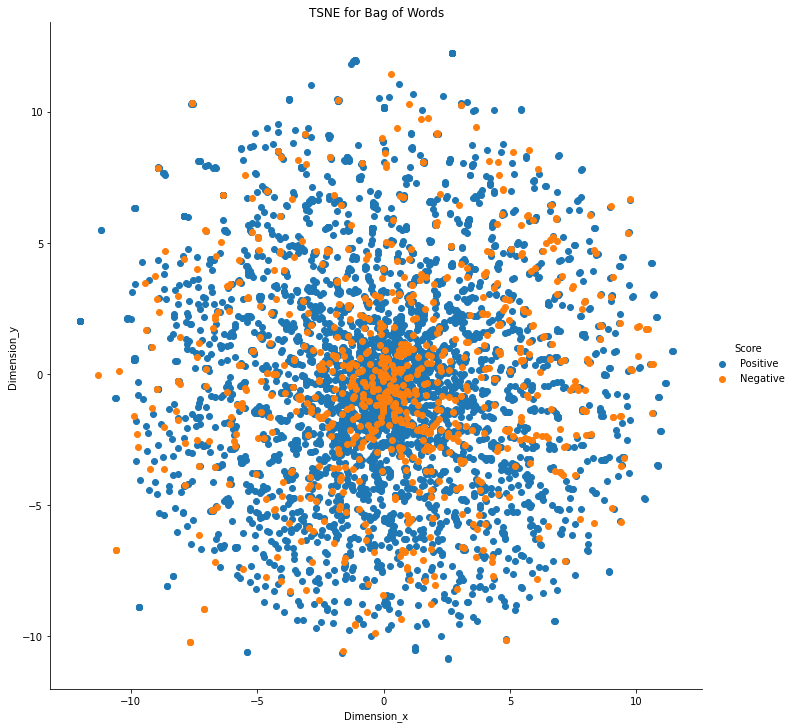

In [36]:
from sklearn.manifold import TSNE
from sklearn import datasets
import pandas as pd
import matplotlib.pyplot as plt

model = TSNE(n_components=2, perplexity=45, learning_rate=100, n_iter = 500, random_state=0)

for_tsne = model.fit_transform(std_data)
# if x is a sparse matrix you need to pass it as X_embedding = tsne.fit_transform(x.todense()) , .toarray() will convert the sparse matrix into dense matrix

for_tsne = np.vstack((for_tsne.T, score)).T
for_tsne_df = pd.DataFrame(data=for_tsne, columns=['Dimension_x','Dimension_y','Score'])
sns.FacetGrid(for_tsne_df, hue="Score", size=10).map(plt.scatter, 'Dimension_x', 'Dimension_y').add_legend()
plt.title("TSNE for Bag of Words")

In [37]:
from sklearn.preprocessing import StandardScaler

std_data1 = StandardScaler(with_mean = False).fit_transform(final_tf_idf)
print(std_data1.shape)
type(std_data1)
std_data1=std_data1.todense()
type(std_data1)

(4986, 3144)


numpy.matrix

Text(0.5, 1.0, 'TF-IDF')

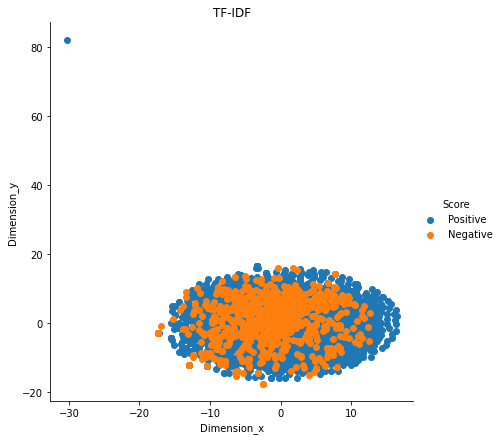

In [38]:
model = TSNE(n_components=2, perplexity=40, learning_rate=100, n_iter=500)

for_tsne = model.fit_transform(std_data1)
# if x is a sparse matrix you need to pass it as X_embedding = tsne.fit_transform(x.todense()) , .toarray() will convert the sparse matrix into dense matrix

for_tsne = np.vstack((for_tsne.T, score)).T
for_tsne_df = pd.DataFrame(data=for_tsne, columns=['Dimension_x','Dimension_y','Score'])
sns.FacetGrid(for_tsne_df, hue="Score", size=6).map(plt.scatter, 'Dimension_x', 'Dimension_y').add_legend()
plt.title("TF-IDF")

In [39]:
from sklearn.preprocessing import StandardScaler

std_data2 = StandardScaler(with_mean = False).fit_transform(sent_vectors)
print(std_data2.shape)
type(std_data2)
type(std_data2)

(4986, 50)


numpy.ndarray

Text(0.5, 1.0, 'AVG W2V')

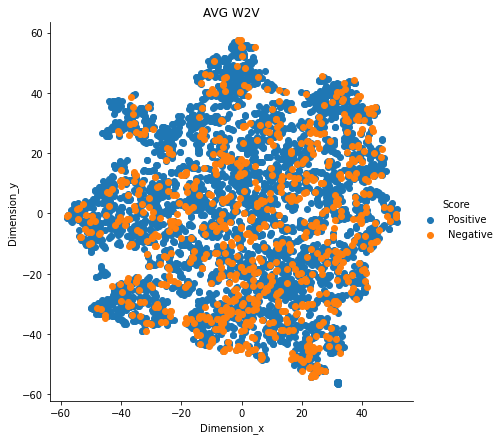

In [40]:
model = TSNE(n_components=2, perplexity=30, learning_rate=600, n_iter=500)

for_tsne = model.fit_transform(std_data2)
# if x is a sparse matrix you need to pass it as X_embedding = tsne.fit_transform(x.todense()) , .todense() will convert the sparse matrix into dense matrix

for_tsne = np.vstack((for_tsne.T, score)).T
for_tsne_df = pd.DataFrame(data=for_tsne, columns=['Dimension_x','Dimension_y','Score'])
sns.FacetGrid(for_tsne_df, hue="Score", size=6).map(plt.scatter, 'Dimension_x', 'Dimension_y').add_legend()
plt.title("AVG W2V")

In [41]:
from sklearn.preprocessing import StandardScaler

std_data3 = StandardScaler(with_mean = False).fit_transform(tfidf_sent_vectors)
print(std_data3.shape)
type(std_data3)
type(std_data3)

(4986, 50)


numpy.ndarray

Text(0.5, 1.0, 'Weighted W2V')

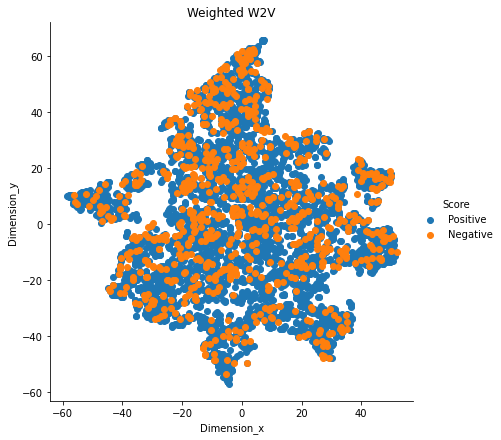

In [42]:
model = TSNE(n_components=2, perplexity=40, learning_rate=600, n_iter=500)

for_tsne = model.fit_transform(std_data3)
# if x is a sparse matrix you need to pass it as X_embedding = tsne.fit_transform(x.todense()) , .todense() will convert the sparse matrix into dense matrix

for_tsne = np.vstack((for_tsne.T, score)).T
for_tsne_df = pd.DataFrame(data=for_tsne, columns=['Dimension_x','Dimension_y','Score'])
sns.FacetGrid(for_tsne_df, hue="Score", size=6).map(plt.scatter, 'Dimension_x', 'Dimension_y').add_legend()
plt.title("Weighted W2V")